# 3-5 迁移注释

## 1. 背景

迁移注释实际上是自动注释的一类，与我们在3-4中介绍的自动注释不同，迁移注释需要我们有一个已经注释好的单细胞测序数据文件，而不是训练好的模型或者marker。我们需要使用这个已经注释好的单细胞测序数据文件来训练一个新的模型，例如Cell-Blast或者是Tosica等。

此外，对于多个样本的单细胞测序文件，我们可以先主动注释好一个样本，然后使用迁移注释的方式，把剩下的样本也一起注释了。在这里，我们将介绍迁移注释的SOTA算法，TOSICA。TOSICA 实现了快速、准确的一站式注释和对批量不敏感的整合，同时为理解发育和疾病进展过程中的细胞行为提供了可解释的生物学见解。

In [37]:
import omicverse as ov
print(f'omicverse version: {ov.__version__}')
import scanpy as sc
print(f'scanpy version: {sc.__version__}')
ov.ov_plot_set()

omicverse version: 1.5.1
scanpy version: 1.9.1


## 2. 加载数据

需要注意的是，参考单细胞测序数据与要注释的单细胞测序数据要保持一致的归一化方法。归一化方法通常受`sc.pp.normalize_total`中`target_sum`参数的影响，在scanpy中，默认值为自适应，这会导致我们在迁移注释时出错，为了避免这种情况的出现，我们需要将其统一，不能留空。网上的教程包括seurat会将`target_sum`设置为`1e4`

而如果你是使用omicverse的`preprocess`函数进行的归一化，那么默认`target_sum`为`50*1e4`。而在本教程中，我们将统一使用原始counts，然后使用omicverse的preprocess函数进行预处理与归一化

### 2.1 参考注释数据集

一个高质量的参考注释数据集对我们注释结果的影响是至关重要的，在这里，我们介绍[Cell Blast参考注释数据集](https://cblast.gao-lab.org/download)，Cell Blast收集了100+个高质量的单细胞注释数据集，我们从中下载了`Zheng`来注释我们的骨髓数据集。

需要注意的是，我们用来训练的参考数据集不能少于30,000个细胞，否则训练出来的TOSICA模型效果一般，如果参考数据集大于100,000个细胞，我们也可以随机选择30,000个细胞进行训练，效果是一样的。



In [2]:
!wget https://cblast.gao-lab.org/Zheng/Zheng.h5ad

--2023-08-31 19:21:26--  https://cblast.gao-lab.org/Zheng/Zheng.h5ad
Resolving cblast.gao-lab.org (cblast.gao-lab.org)... 159.138.49.219
Connecting to cblast.gao-lab.org (cblast.gao-lab.org)|159.138.49.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500776712 (478M) [application/octet-stream]
Saving to: ‘Zheng.h5ad’

Zheng.h5ad          100%[===================>] 477.58M  3.85MB/s    in 1m 56s  

2023-08-31 19:23:23 (4.12 MB/s) - ‘Zheng.h5ad’ saved [500776712/500776712]



In [23]:
ref_adata = ov.utils.read('Zheng.h5ad')
ref_adata

AnnData object with n_obs × n_vars = 91789 × 32643
    obs: 'cell_type1', 'lifestage', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'variable_genes'
    uns: 'cell_ontology_class_colors', 'cell_type1_colors', 'data_quality', 'known_markers', 'neighbors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

随机选取30,000个细胞的方法，我们使用random.sample进行无放回采样

In [22]:
import random
cell_idx=list(random.sample(ref_adata.obs.index.tolist(),30000))
ref_adata=ref_adata[cell_idx]
ref_adata

View of AnnData object with n_obs × n_vars = 3000 × 2398
    obs: 'cell_type1', 'lifestage', 'organism', 'dataset_name', 'platform', 'organ', 'data_type', 'cell_ontology_class', 'cell_ontology_id', 'n_genes', 'n_counts', '__libsize__'
    var: 'variable_genes', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'cell_ontology_class_colors', 'cell_type1_colors', 'data_quality', 'known_markers', 'neighbors', 'umap', 'log1p', 'hvg'
    obsm: 'X_umap', 'latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [24]:
ref_adata.obs['cell_ontology_class'].cat.categories

Index(['B cell', 'T-helper 2 cell', 'cytotoxic T cell', 'dendritic cell',
       'hematopoietic precursor cell', 'memory T cell', 'monocyte',
       'naive thymus-derived CD4-positive, alpha-beta T cell',
       'naive thymus-derived CD8-positive, alpha-beta T cell',
       'natural killer cell', 'regulatory T cell'],
      dtype='object')

我们检查其归一化程度

In [25]:
ref_adata.X.max()

173.0

这是一个较大的整数，表明其并未进行归一化，是原始counts，我们对其进行预处理（包括归一化与高可变基因的计算）。

In [26]:
ref_adata=ov.pp.preprocess(ref_adata,mode='shiftlog|pearson',n_HVGs=3000)

Begin robust gene identification
After filtration, 21666/32643 genes are kept. Among 21666 genes, 13971 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['IGLL5']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


### 2.2 待注释数据集

我们还是使用之前的骨髓数据集，为了保持我们分析的一致性，但是我们需要从中先提取原始counts，因为我们在2-2的章节中对数据进行了归一化与高可变基因的筛选

In [27]:
adata = ov.utils.read('data/s4d8_manual_annotation.h5ad')
adata=adata.raw.to_adata()
ov.utils.retrieve_layers(adata,layers='counts')
print('raw count adata:',adata.X.max())

......The X of adata have been stored in raw
......The layers counts of adata have been retreved
raw count adata: 889.0


In [28]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000)

Begin robust gene identification
After filtration, 20171/20171 genes are kept. Among 20171 genes, 20171 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


### 2.3 高可变基因一致化

我们对`ref_adata`与`adata`都提取了3000个高可变基因，但是这两个单细胞测序数据的高可变基因不一致，所以我们需要提取相同的高可变基因来进行分析。

In [29]:
#提取高可变基因
ref_adata = ref_adata[:, ref_adata.var.highly_variable_features]

#提取共同高可变基因
ref_adata.var_names_make_unique()
adata.var_names_make_unique()
ret_gene=list(set(adata.var_names) & set(ref_adata.var_names))
len(ret_gene)

2398

我们发现参考数据集的高可变基因与目标数据集的共同基因只有2132个，我们可以将前面3000个高可变基因调高来保证取到的高可变基因重复率较高

In [30]:
adata=adata[:,ret_gene]
ref_adata=ref_adata[:,ret_gene]

我们此时再看ref_adata与adata的最大值，发现其都在`np.log1p(50*1e4)`内，表明二者具有相同的归一化值。

In [31]:
print(f"The max of ref_adata is {ref_adata.X.max()}, query_data is {adata.X.max()}",)

The max of ref_adata is 11.416531562805176, query_data is 10.87752914428711


## 3. 下载通路注释集

TOSICA作为一个transformer模型，具有多头注意力机制，这意味我们除了注释以外，还可以分析细胞的注意力主要位于什么通路上，所以我们可以将通路数据作为输入给予TOSICA模型。

你可以使用ov.utils.download_tosica_gmt()来自动下载，也可以通过下面的链接手动下载：

- 'GO_bp':'https://figshare.com/ndownloader/files/41460072',
- 'TF':'https://figshare.com/ndownloader/files/41460066',
- 'reactome':'https://figshare.com/ndownloader/files/41460051',
- 'm_GO_bp':'https://figshare.com/ndownloader/files/41460060',
- 'm_TF':'https://figshare.com/ndownloader/files/41460057',
- 'm_reactome':'https://figshare.com/ndownloader/files/41460054',
- 'immune':'https://figshare.com/ndownloader/files/41460063',

In [ ]:
ov.utils.download_tosica_gmt()

## 4. 初始化 TOSICA 模型

我们首先需要在 He_Calvarial_Bone 数据集上训练 TOSICA 模型，omicverse 提供了一个简单的 `pyTOSICA` 类，所有后续操作都可以使用 `pyTOSICA` 完成。我们需要设置模型初始化的参数。

- `adata`：参考 adata 对象
- `gmt_path`：默认的预先准备的掩码，或者 .gmt 文件的路径。您可以使用 `ov.utils.download_tosica_gmt()` 来获取基因集。
- `depth`：Transformer 模型的深度，设置为 2 时可能会发生内存泄漏。
- `label_name`：在 `adata.obs` 中表示细胞类型的参考键。
- `project_path`：TOSICA 模型的保存路径。
- `batch_size`：表示在单次传递中传递给程序进行训练的细胞数量。

In [32]:
tosica_obj=ov.single.pyTOSICA(adata=ref_adata,
                              gmt_path='genesets/GO_bp.gmt', depth=1,
                              label_name='cell_ontology_class',
                              project_path='hGOBP_demo',
                              batch_size=8)

cuda:0
Mask loaded!


## 5. 训练 TOSICA 模型

训练 TOSICA 模型时需要设置 4 个参数。

- pre_weights： 预训练权重的路径。
- lr： 学习率。
- epochs：epochs 的个数。
- lrf： 最后一层的学习率。

In [33]:
tosica_obj.train(epochs=5)

Model builded!


[valid epoch 4] loss: 0.273, acc: 0.891: 100%|██████████| 4930/4930 [00:14<00:00, 330.70it/s]


Training finished!


Transformer(
  (feature_embed): FeatureEmbed(
    (fe): CustomizedLinear(input_features=2398, output_features=14400, bias=True)
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=48, out_features=144, bias=True)
        (attn_drop): Dropout(p=0.5, inplace=False)
        (proj): Linear(in_features=48, out_features=48, bias=True)
        (proj_drop): Dropout(p=0.5, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=48, out_features=192, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=192, out_features=48, bias=True)
        (drop): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (norm): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
  (pre_logits): Identity()
  (head): Linear(in_feat

我们可以使用 `.save` 来保存 `TOSICA`模型到 `project_path`

In [ ]:
tosica_obj.save()
tosica_obj.load()

## 6. 细胞类型预测

在训练好TOSICA模型后，我们将其注释结果迁移到目标数据上

In [34]:
new_adata=tosica_obj.predicted(pre_adata=adata)

0
10000
14814


In [35]:
new_adata.obsm=adata[new_adata.obs.index].obsm.copy()
new_adata.obsp=adata[new_adata.obs.index].obsp.copy()
new_adata

AnnData object with n_obs × n_vars = 14814 × 299
    obs: 'Prediction', 'Probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'leiden_res1', 'major_celltype', 'manual_celltype', 'minor_celltype'
    obsm: 'X_mde', 'scaled|original|X_pca'
    obsp: 'connectivities', 'distances'

[<AxesSubplot: title={'center': 'major_celltype'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'Prediction'}, xlabel='X_mde1', ylabel='X_mde2'>]

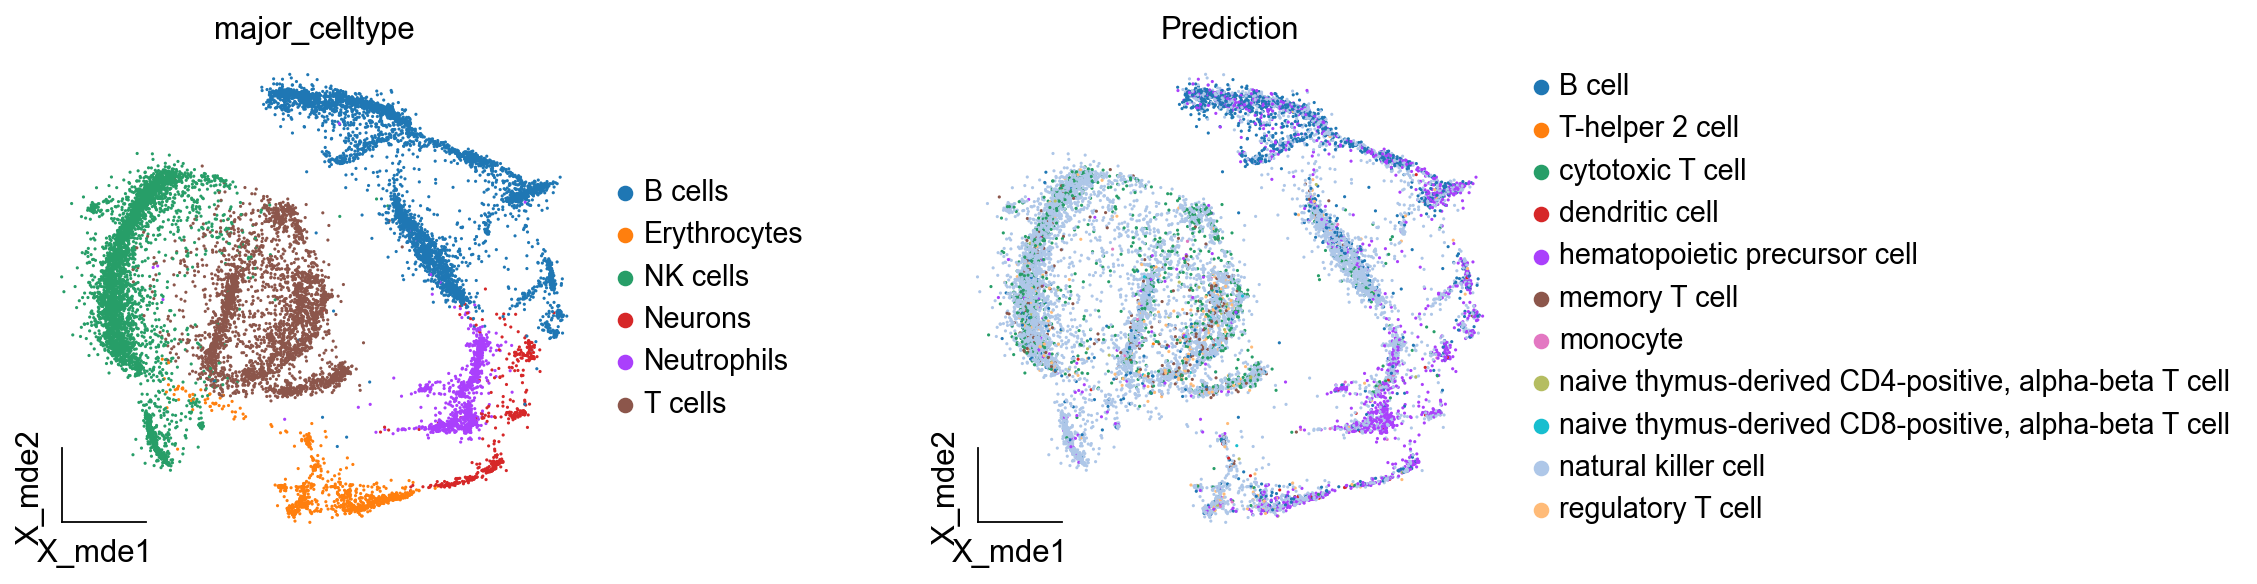

In [36]:
ov.utils.embedding(
    new_adata,
    basis="X_mde",
    color=['major_celltype', 'Prediction'],
    frameon='small',
    #ncols=1,
    wspace=0.5,
    #palette=ov.utils.pyomic_palette()[11:],
    show=False,
)

我们可以看见，其注释效果一般，这是由于我们是用PBMC外周血的细胞类型进行迁移，而不是使用骨髓数据进行迁移。所以参考数据集的选取对于注释准确率的影响非常大，一般我们手动注释一个样本然后进行迁移的准确率是最高的。

## 7. 注意力机制

transformer作为一个注意力模型，我们可以找到每一类细胞注意力集中的通路，这听起来有点类似通路富集。我们首先将预测细胞类型数量小于5的细胞给过滤掉。

In [38]:
cell_idx=new_adata.obs['Prediction'].value_counts()[new_adata.obs['Prediction'].value_counts()<5].index
new_adata=new_adata[~new_adata.obs['Prediction'].isin(cell_idx)]

然后，我们使用 `sc.tl.rank_genes_groups` 计算出各细胞类型中注意力最高的差异通路。这种差异通路来源于之前计算所用的 gmt 基因组。

In [39]:
sc.tl.rank_genes_groups(new_adata, 'Prediction', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Prediction']`


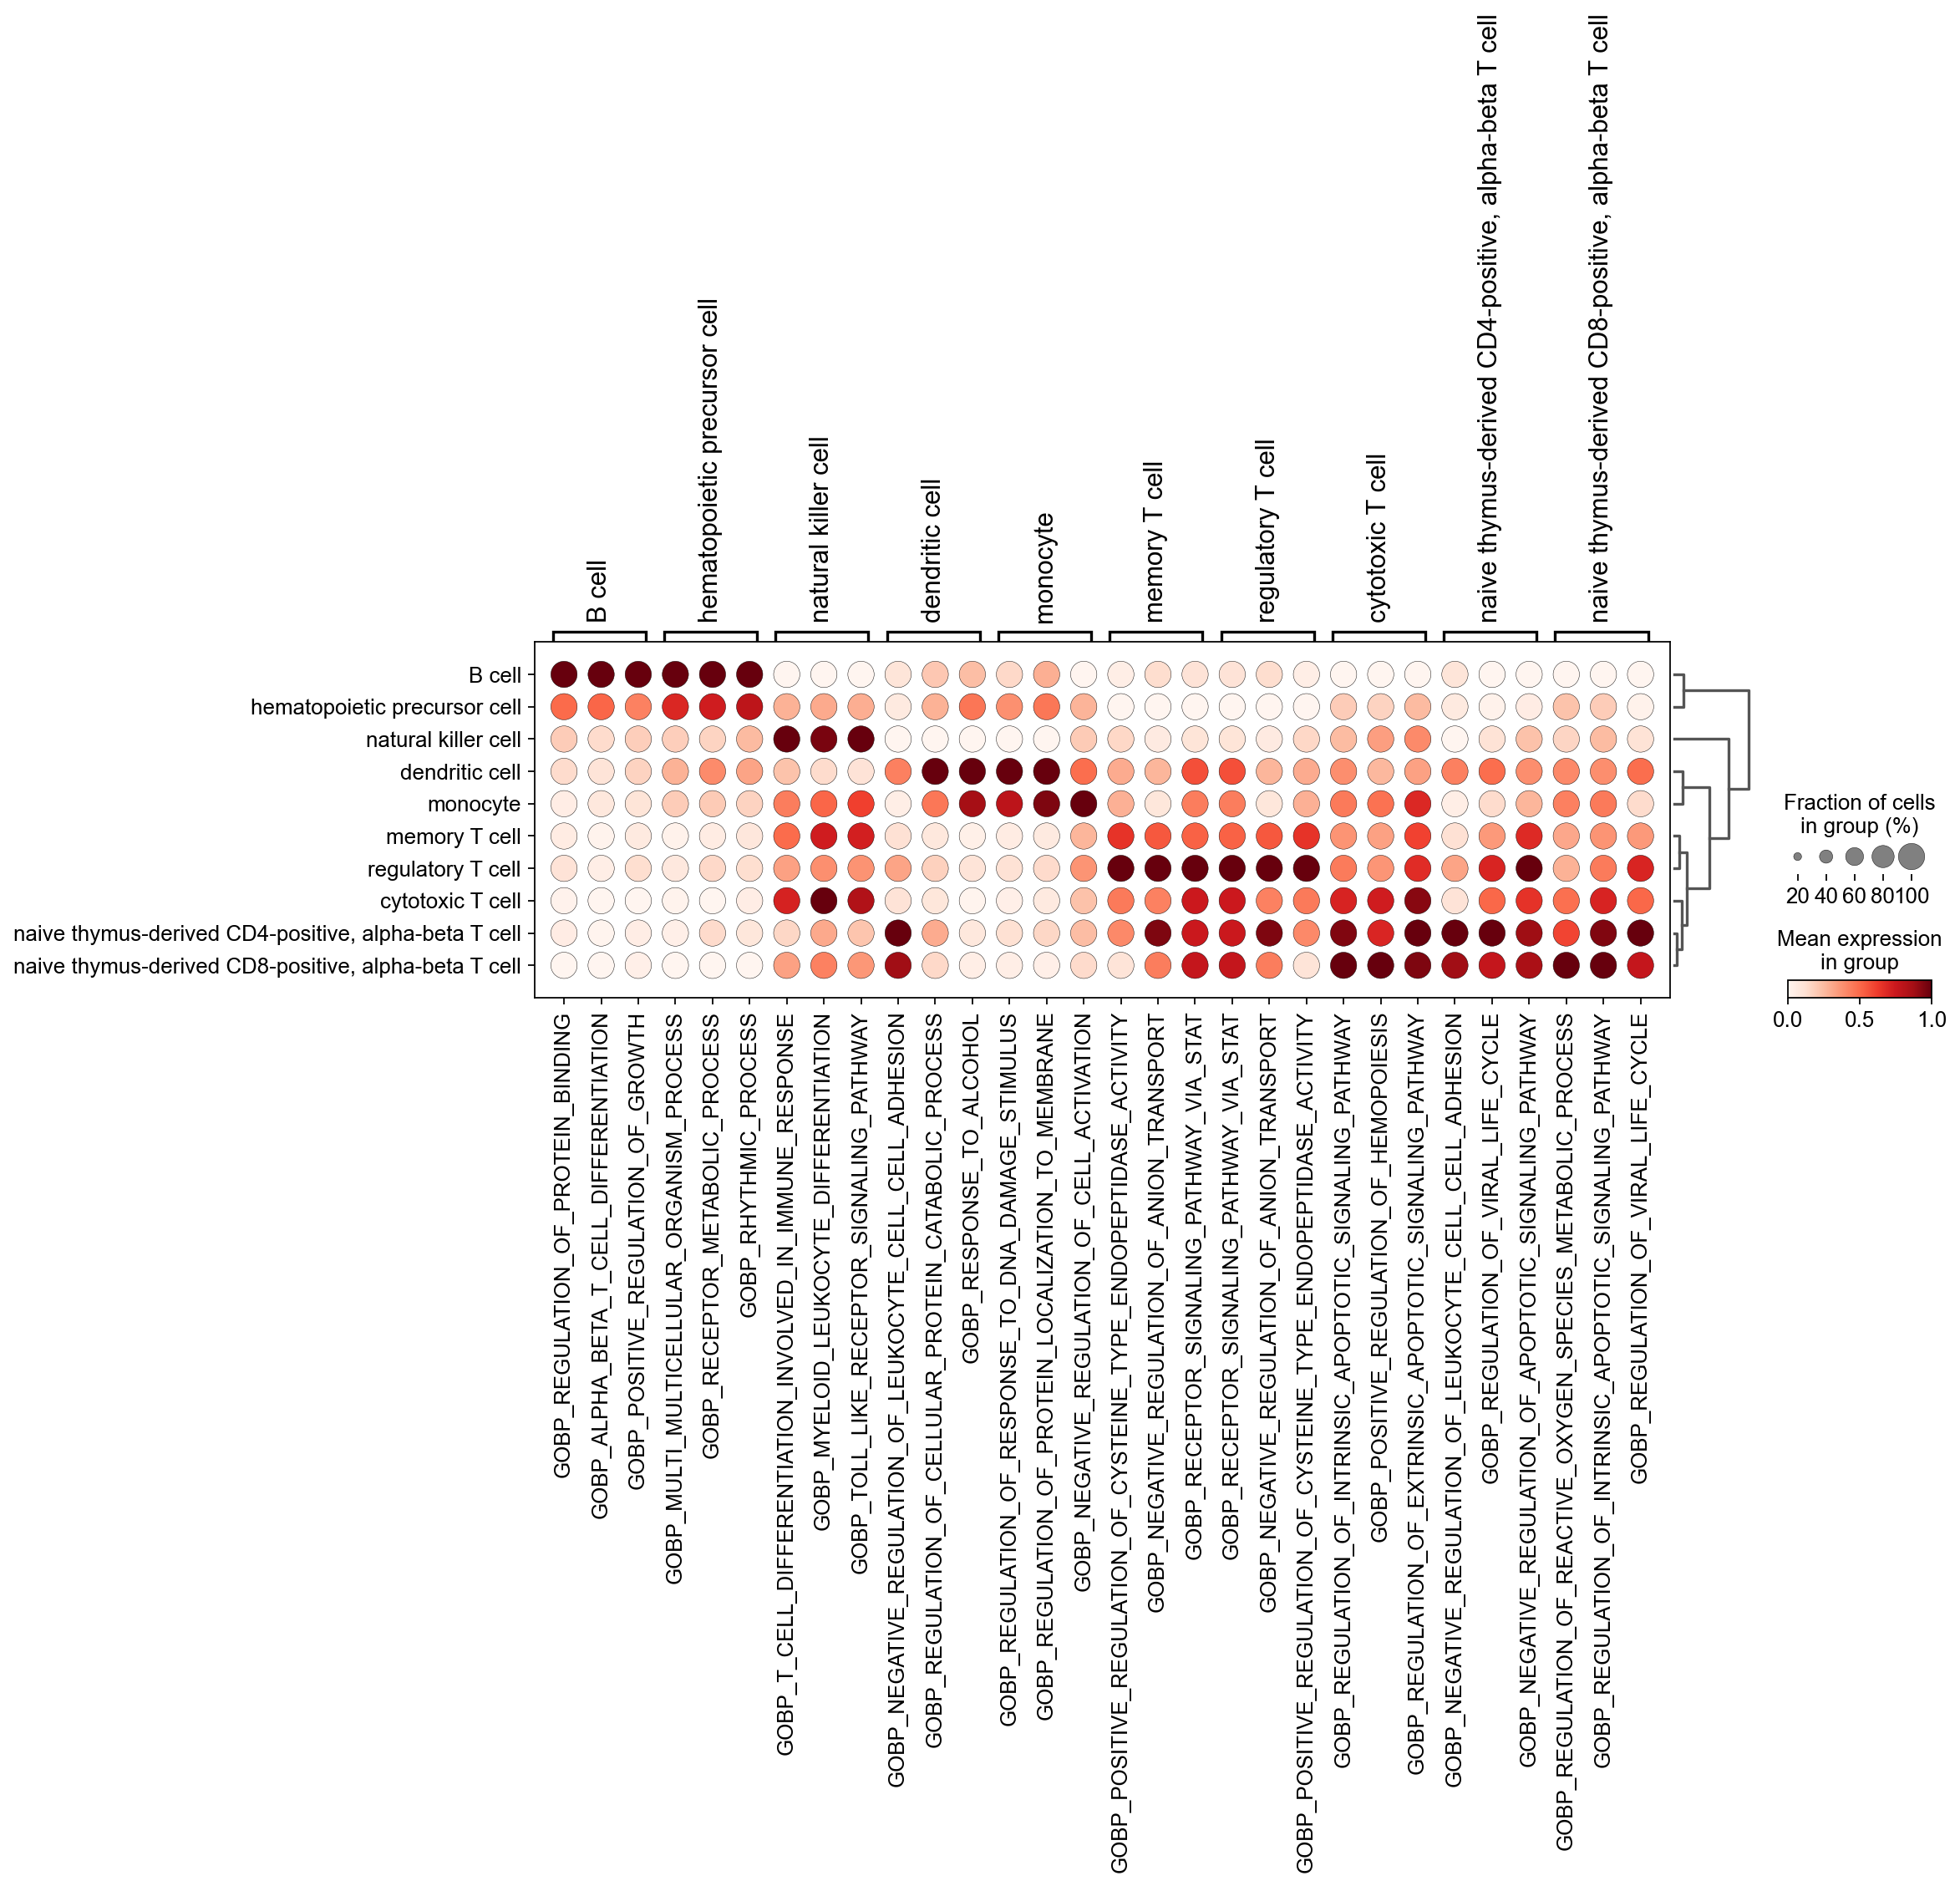

In [40]:
sc.pl.rank_genes_groups_dotplot(new_adata,
                                n_genes=3,standard_scale='var',)

如果想获取特定细胞的通路，可以使用 sc.get.rank_genes_groups_df 来获取。

例如，我们想获得细胞类型 B细胞 注意力最高的通路

In [41]:
degs = sc.get.rank_genes_groups_df(new_adata, group='B cell', key='rank_genes_groups',
                                            pval_cutoff=0.05)
degs.head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,GOBP_REGULATION_OF_PROTEIN_BINDING,47.931641,2.096211,0.0,0.0
1,GOBP_ALPHA_BETA_T_CELL_DIFFERENTIATION,46.784363,2.175920,0.0,0.0
2,GOBP_POSITIVE_REGULATION_OF_GROWTH,45.234039,1.797564,0.0,0.0
3,GOBP_REGULATION_OF_HORMONE_SECRETION,44.887436,1.623285,0.0,0.0
4,GOBP_ENDOTHELIAL_CELL_MIGRATION,44.318310,1.791468,0.0,0.0


我们发现注意力最高的通路是`GOBP_REGULATION_OF_PROTEIN_BINDING`，我们在umap图上观察通路的注意力情况，发现其确实位于B细胞区域

[<AxesSubplot: title={'center': 'Prediction'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'GOBP_REGULATION_OF_PROTEIN_BINDING'}, xlabel='X_mde1', ylabel='X_mde2'>]

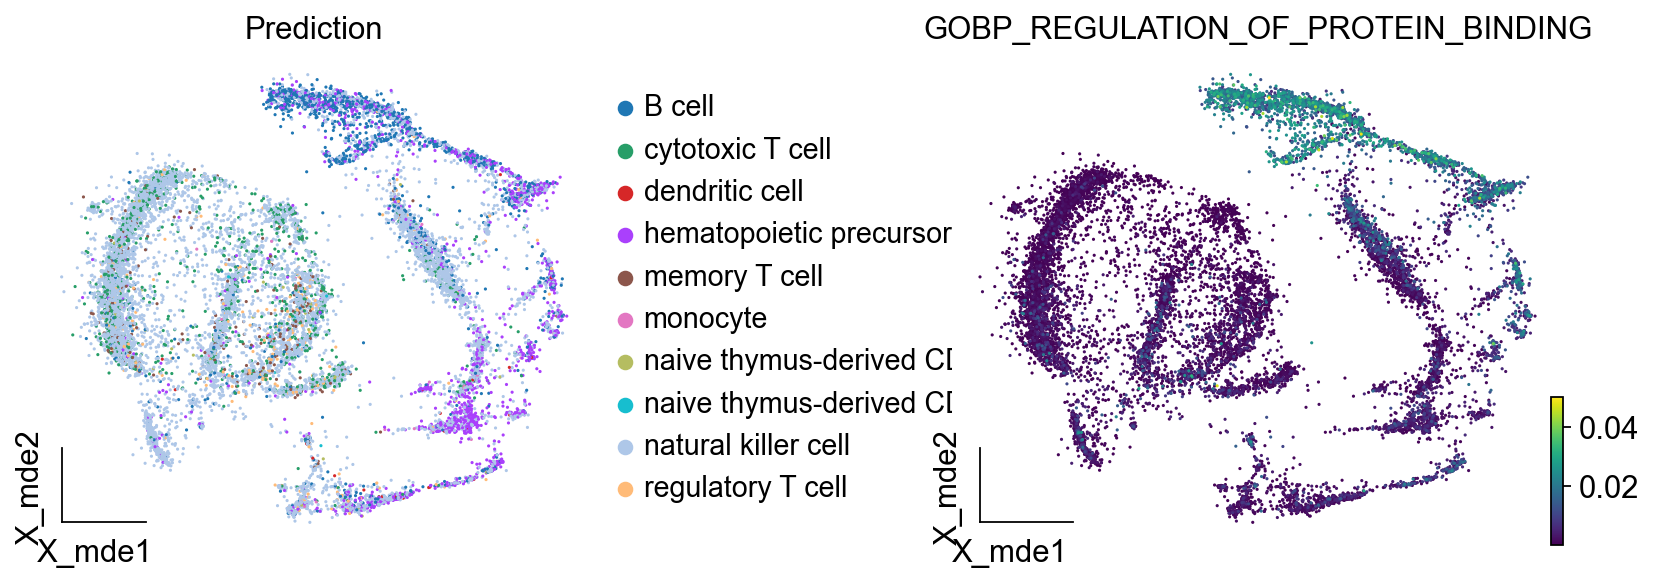

In [42]:
ov.utils.embedding(
    new_adata,
    basis="X_mde",
    color=['Prediction','GOBP_REGULATION_OF_PROTEIN_BINDING'],
    frameon='small',
    #ncols=1,
    wspace=0.5,
    #palette=ov.utils.pyomic_palette()[11:],
    show=False,
)